In [1]:
%config InlineBackend.figure_format = "svg"


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection


In [3]:
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))
from IPython.display import display, HTML

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


In [4]:
R = 6.35 / 2
Rg = R * 1.08
dR = R * 0.08 / np.sqrt(2)
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dR, -dR],[-dR, dR]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dR, dR],[dR, -dR]]), R=np.array([Rg, Rg]))

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
n_slice = 21
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
SliceForceRatio = TB.SliceForceRatio(n_slice)
mu = 0.10


In [5]:
p0 = np.array([[4,0,0], [5,0,0]])
x0 = np.array([2,0,0])
v0 = np.array([0,0,100])
w0 = np.array([0,0,5])

TB.surface_velocity(x0, p0, v0, w0)


array([[  0,  10, 100],
       [  0,  15, 100]])

In [6]:
def vaT_ball(xvw_ball, t, R, SP12, v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I):
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    Zeros = np.zeros(3)
    F_sum = Zeros.copy()
    T_sum = Zeros.copy()
    vr = np.linalg.norm(v_ball)

    for iSP, SP in enumerate(SP12):
        for i in range(2):
            cos_sin1, dx1, exyz1 = SP.get_contact(x_ball, R, i)
            if dx1 > 0:
                SP_r_inv = SP.get_rho(cos_sin1[0], i)
                R_Reduced1 = 1.0 / (Ball_r_inv + SP_r_inv)
                k1, a1, b1 = TB.BrewHamrock(R_Reduced1[0], R_Reduced1[1], dx1, E_Reduced)
                v1 = v_ball.dot(exyz1)
                F1_norm = TB.Tsuji(k1, zeta, Ball_m, v1, dx1)
                F1 = - F1_norm * exyz1

                eta1 = SP.to_eta2(x_ball)
                xyz2eta1 = SP.get_xyz2eta(eta1[0])
                b_dir = xyz2eta1.T @ np.array([1.0, 0.0, 0.0])
                a_dir = np.cross(b_dir, exyz1)
                
                peak = x_ball + (R - dx1 / 2) * exyz1
                r_slice = (np.arange(n_slice) - n_slice / 2 + 0.5) / n_slice * 2
                a_slice = a1 * r_slice
                b_slice = b1 * r_slice
                p_slice = peak + a_slice.reshape(-1, 1) @ a_dir.reshape(1, -1) - 0.5 * np.square(a_slice).reshape(-1, 1) / R @ exyz1.reshape(1, -1)
                SP_v = TB.surface_velocity(Zeros, p_slice, v12[iSP], w12[iSP])
                BL_v = TB.surface_velocity(x_ball, p_slice, v_ball, w_ball)
                dv = BL_v - SP_v
                F_slice = F1_norm * SliceForceRatio
                v_dir = dv.T * (1 / np.sqrt(np.square(dv).sum(1)))
                muF = - F_slice * v_dir * mu
                muT = TB.calc_Torque(x_ball, p_slice, muF.T)
                F_sum = F_sum + F1 + muF.sum(1)
                T_sum = T_sum + muT.sum(0)
                
    a_ball = F_sum / Ball_m * 1e6
    T_ball = T_sum / Ball_I * 1e6
    
    return np.concatenate([v_ball, a_ball, T_ball])


In [17]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = -10 * np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = 10 *np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])


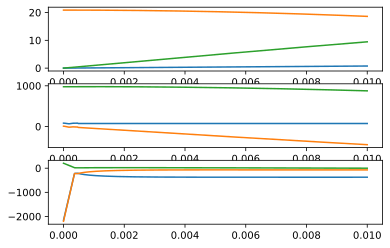

In [18]:
from scipy.integrate import odeint
t = np.linspace(0, 0.01, 1000)
sol = odeint(vaT_ball, xvw_ball, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()


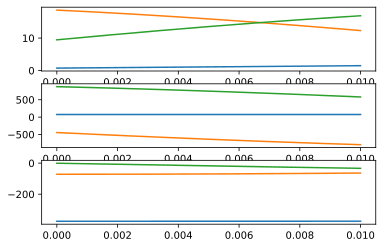

In [19]:
xvw_ball = sol[-1, :]

sol = odeint(vaT_ball, xvw_ball, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()

In [20]:
xvw_ball = sol[-1, :]
xvw_ball


array([   1.49873873,   12.30192895,   16.86701116,   74.88767947,
       -793.64753825,  578.8457728 , -373.68222526,  -63.64471884,
        -33.3023863 ])

In [21]:
x_ball0 = xvw_ball[0:3]
v_ball0 = xvw_ball[3:6]
w_ball0 = xvw_ball[6:9]
eta1 = SP1.to_eta2(x_ball0)
th1 = eta1[0]

v_eta1 = SP1.get_xyz2eta(th1) @ v_ball0
v_eta1


array([ 9.85163442e+02, -1.59391131e-02, -5.70311786e-03])

In [22]:
w_eta1 = SP1.get_xyz2eta(th1) @ w_ball0

In [23]:
eta2 = SP2.to_eta2(x_ball0)
th2 = eta1[0]

v_eta2 = SP2.get_xyz2eta(th2) @ v_ball0
v_eta2


array([ 9.85157530e+02,  3.41297327e+00, -5.25239168e-03])

In [24]:
th1_new = 0.0
eta1_new = eta1.copy()
eta1_new[0] = th1_new

x_ball0_new = SP1.to_xyz(eta1_new)
v_ball0_new = SP1.get_xyz2eta(th1_new).T @ v_eta1
w_ball0_new = SP1.get_xyz2eta(th1_new).T @ w_eta1

xvw_ball0_new = np.concatenate([x_ball0_new, v_ball0_new, w_ball0_new])
xvw_ball0_new


array([ 4.40988468e-03,  2.08765950e+01,  3.61003505e-02,  7.48876795e+01,
       -1.69851967e+00,  9.82311539e+02, -3.73682225e+02, -6.44649374e+01,
        3.16855017e+01])

In [25]:
x_ball = np.array([0.0, PCR, 0.0])
v_ball = - np.array([ -16.66666666, -1.8005798, -195.28004922]) / 2
w_ball = np.array([-0.69860631, -0.71243783, 0.06619335]) * np.linalg.norm(v_ball) / R
xvw_ball = np.concatenate([x_ball, v_ball, w_ball])
xvw_ball

array([  0.        ,  20.875     ,   0.        ,   8.33333333,
         0.9002899 ,  97.64002461, -21.56308983, -21.99001169,
         2.04311517])

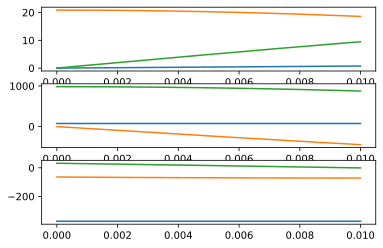

In [26]:
sol = odeint(vaT_ball, xvw_ball0_new, t, args=(R, [SP1, SP2], v12, w12, Ball_r_inv, zeta, E_Reduced, n_slice, SliceForceRatio, mu, Ball_m, Ball_I))

fig, ax = plt.subplots(3)
ax[0].plot(t[:], sol[:, 0:3])
ax[1].plot(t[:], sol[:, 3:6])
ax[2].plot(t[:], sol[:, 6:9])

plt.show()

In [44]:
x_ball = xvw_ball0_new[0:3]
v_ball = xvw_ball0_new[3:6]
w_ball = xvw_ball0_new[6:9]
Zeros = np.zeros(3)
F1 = np.zeros([2, 2, 3])
muF1 = F1.copy()
dx1_ = np.zeros([2, 2])
T1 = F1.copy()
dv1 = np.zeros([2, 2, 21, 3])

for iSP, SP in enumerate([SP1, SP2]):
    for i in range(2):
        cos_sin1, dx1, exyz1 = SP.get_contact(x_ball, R, i)
        dx1_[iSP, i] = dx1
        if dx1 > 0:
            SP_r_inv = SP.get_rho(cos_sin1[0], i)
            R_Reduced1 = 1.0 / (Ball_r_inv + SP_r_inv)
            k1, a1, b1 = TB.BrewHamrock(R_Reduced1[0], R_Reduced1[1], dx1, E_Reduced)
            v1 = v_ball.dot(exyz1)
            F1_norm = TB.Tsuji(k1, zeta, Ball_m, v1, dx1)
            F1[iSP, i, :] = - F1_norm * exyz1

            eta1 = SP.to_eta2(x_ball)
            xyz2eta1 = SP.get_xyz2eta(eta1[0])
            b_dir = xyz2eta1.T @ np.array([1.0, 0.0, 0.0])
            a_dir = np.cross(b_dir, exyz1)

            peak = x_ball + (R - dx1 / 2) * exyz1
            r_slice = (np.arange(n_slice) - n_slice / 2 + 0.5) / n_slice * 2
            a_slice = a1 * r_slice
            b_slice = b1 * r_slice
            p_slice = peak + a_slice.reshape(-1, 1) @ a_dir.reshape(1, -1) - 0.5 * np.square(a_slice).reshape(-1, 1) / R @ exyz1.reshape(1, -1)
            SP_v = TB.surface_velocity(Zeros, p_slice, v12[iSP], w12[iSP])
            BL_v = TB.surface_velocity(x_ball, p_slice, v_ball, w_ball)
            dv = BL_v - SP_v
            dv1[iSP, i, :, :] = dv
            F_slice = F1_norm * SliceForceRatio
            v_dir = dv.T * (1 / np.sqrt(np.square(dv).sum(1)))
            muF = - F_slice * v_dir * mu
            muT = TB.calc_Torque(x_ball, p_slice, muF.T)
            muF1[iSP, i, :] = muF.sum(1)
            T1[iSP, i, :] = muT.sum(0)


In [36]:
F1

array([[[-37.18945525,  36.06644104,   2.89834651],
        [  0.        ,   0.        ,   0.        ]],

       [[ 36.54554314, -36.75005397,  -2.84970508],
        [ -2.73273507,  -2.78313969,   0.20354783]]])

In [37]:
muF1

array([[[ 1.68766795,  1.73126974,  0.07032425],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 1.70822985,  1.69610497,  0.06738657],
        [-0.01925025, -0.00957651, -0.38998448]]])

In [38]:
dx1_

array([[ 0.00201315, -0.00426937],
       [ 0.00193985,  0.0003676 ]])

In [39]:
F1.sum(0).sum(0) + muF1.sum(0).sum(0)

array([ 3.72956939e-07, -4.89544271e-02, -8.43925332e-05])

In [41]:
T1.sum(0).sum(0)

array([ 2.59194276e-05, -6.39290084e-03, -1.29563030e-02])

In [43]:
dv.shape

(21, 3)

In [45]:
dv1

array([[[[  -4.48793872,   -9.69281976,   90.12324266],
         [  -5.04432513,   -9.79512717,   81.51452296],
         [  -5.60942466,   -9.89607018,   72.7770247 ],
         [  -6.18323729,   -9.99564879,   63.91074789],
         [  -6.76576304,  -10.09386299,   54.91569252],
         [  -7.35700189,  -10.1907128 ,   45.7918586 ],
         [  -7.95695385,  -10.28619821,   36.53924612],
         [  -8.56561893,  -10.38031921,   27.15785509],
         [  -9.18299711,  -10.47307582,   17.64768551],
         [  -9.8090884 ,  -10.56446803,    8.00873737],
         [ -10.44389281,  -10.65449583,   -1.75898932],
         [ -11.08741032,  -10.74315924,  -11.65549457],
         [ -11.73964095,  -10.83045825,  -21.68077837],
         [ -12.40058468,  -10.91639285,  -31.83484073],
         [ -13.07024152,  -11.00096306,  -42.11768164],
         [ -13.74861148,  -11.08416886,  -52.52930111],
         [ -14.43569454,  -11.16601027,  -63.06969913],
         [ -15.13149072,  -11.24648727,  -73.738